Mounted at /content/drive
Dataset unzipped. Check '/content/main_combined_dataset' for images and masks.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 173MB/s]


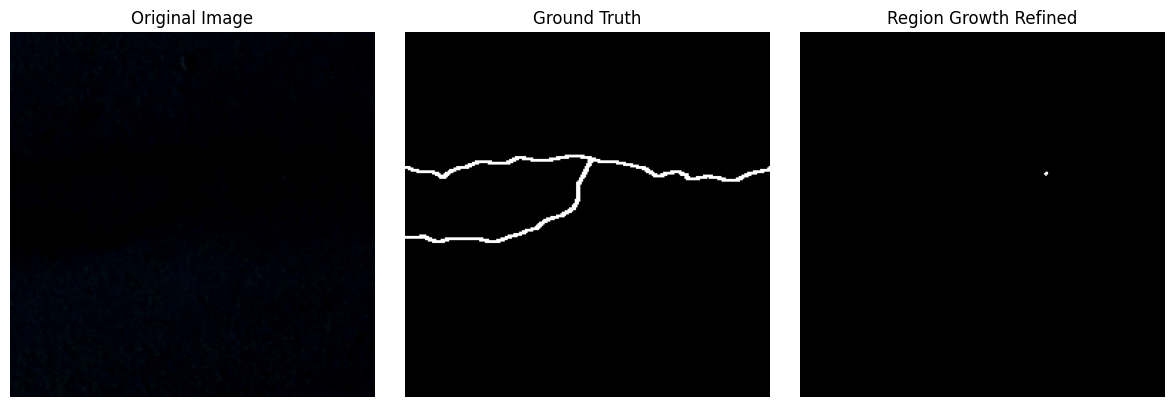

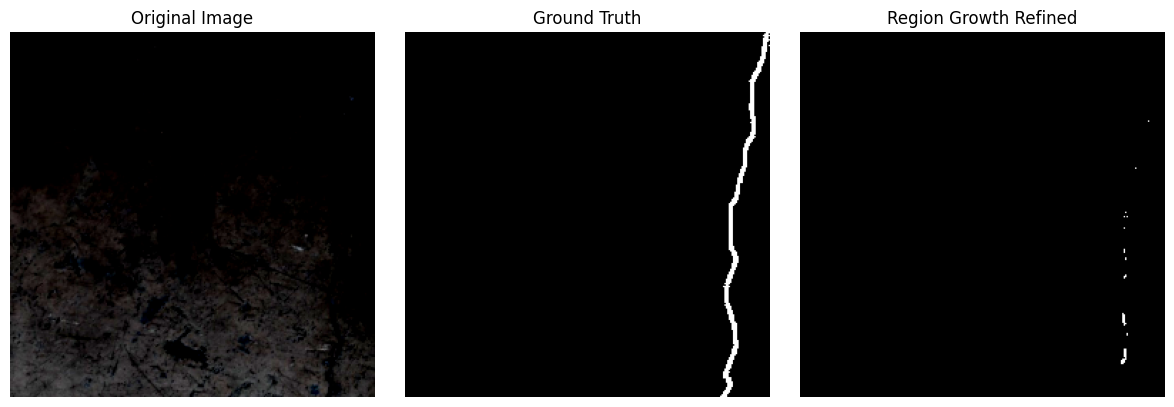

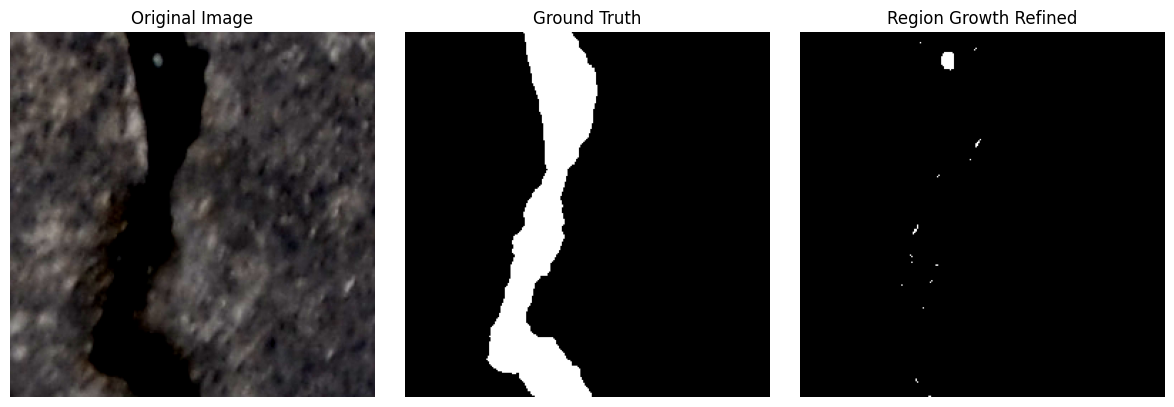

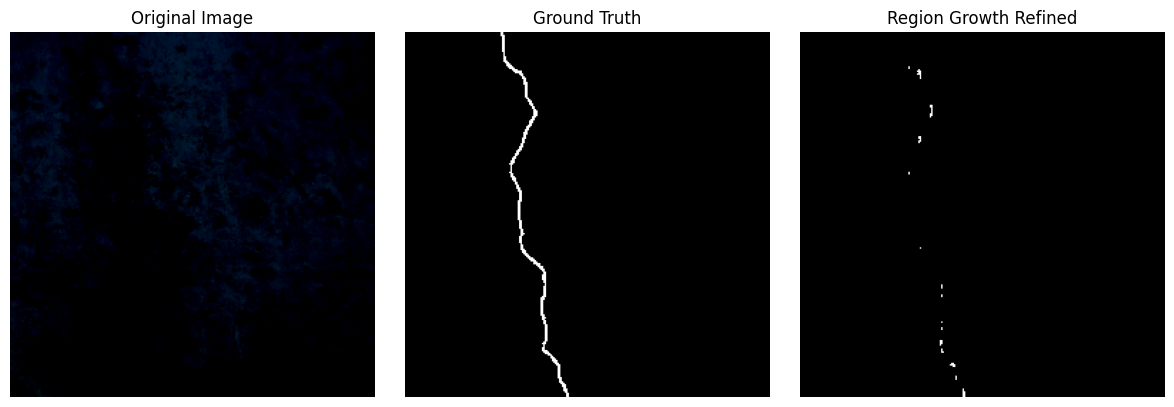

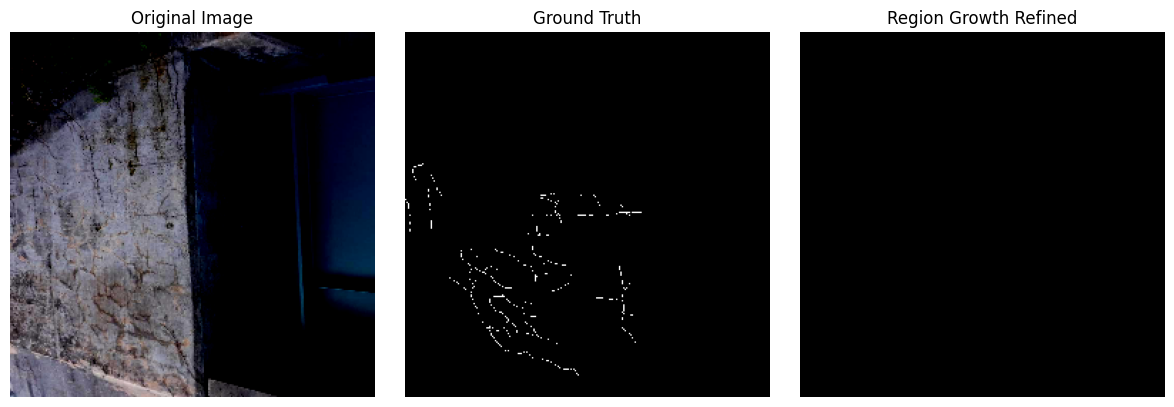

Region growth segmentation refinement complete.


In [ ]:
# ============================
# 0. Mount Google Drive and Unzip Dataset
# ============================
from google.colab import drive
drive.mount("/content/drive")  # Follow prompts to authorize

# Unzip the dataset from Drive (adjust the path if needed)
!unzip -q /content/drive/MyDrive/main_combined_dataset.zip -d /content/
print("Dataset unzipped. Check '/content/main_combined_dataset' for images and masks.")

# ============================
# 1. DATASET AND DATALOADER SETUP
# ============================
import os
import random
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.transforms.functional as TF
import torch
import numpy as np

class DefectSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = sorted(os.listdir(image_dir))
        self.mask_names = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # Load image and mask.
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_names[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # binary mask

        # Apply augmentation if enabled.
        if self.transform:
            image, mask = self.augment(image, mask)

        # Convert to tensor and normalize image (assume normalization: (x-0.5)/0.5).
        image = TF.to_tensor(image)
        image = TF.normalize(image, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        # Convert mask to tensor and binarize.
        mask = TF.to_tensor(mask)
        mask = (mask > 0.5).float()
        return image, mask

    def augment(self, image, mask):
        # Random horizontal flip.
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        # Random vertical flip.
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        # Random rotation.
        angle = random.choice([0, 90, 180, 270])
        image = TF.rotate(image, angle)
        mask = TF.rotate(mask, angle)
        return image, mask

# Set dataset paths (from extracted folder).
image_dir = "/content/main_combined_dataset/images"
mask_dir  = "/content/main_combined_dataset/masks"
full_dataset = DefectSegmentationDataset(image_dir, mask_dir, transform=True)

# Split dataset (e.g., 70% train, 15% val, 15% test).
train_size = int(0.7 * len(full_dataset))
val_size   = int(0.15 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ============================
# 2. DEEPLABv3 MODEL DEFINITION FOR BINARY SEGMENTATION
# ============================
import torch.nn as nn
import torchvision.models as models

def get_deeplabv3(num_classes=1):
    # Load pretrained DeepLabv3 with ResNet50 backbone.
    model = models.segmentation.deeplabv3_resnet50(pretrained=True)
    # Replace the classifier head.
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    return model

# Initialize the model.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_deeplabv3(num_classes=1).to(device)

# ============================
# 3. REGION GROWTH SEGMENTATION FUNCTIONS
# ============================
import cv2

def region_growing_segmentation(gray_img, seed_threshold=10):
    """
    Perform region growth segmentation on a grayscale image using flood fill.
    Parameters:
      gray_img: Grayscale image as a numpy array of shape (H, W) in uint8.
      seed_threshold: Maximum allowed difference for flood fill.
    Returns:
      segmentation: An integer array (H, W) where each unique value is a region label.
    """
    H, W = gray_img.shape
    segmentation = np.zeros((H, W), dtype=np.int32)
    visited = np.zeros((H, W), dtype=bool)
    current_label = 1

    # Loop over each pixel.
    for i in range(H):
        for j in range(W):
            if not visited[i, j]:
                mask = np.zeros((H+2, W+2), np.uint8)  # FloodFill requires a mask 2 pixels larger.
                lo_diff = seed_threshold
                up_diff = seed_threshold
                # Use floodFill; note that (j,i) is in (x,y) order.
                dummy = gray_img.copy()
                ret, dummy, flood_mask, rect = cv2.floodFill(dummy, mask, (j, i), current_label, lo_diff, up_diff, flags=4)
                # The region is given by non-zero values in mask (excluding the added border).
                region = mask[1:-1, 1:-1] != 0
                segmentation[region] = current_label
                visited[region] = True
                current_label += 1
    return segmentation

def refine_with_region_growth(pred_mask, segmentation):
    """
    Refine the predicted binary mask via majority voting within each region (from region growth segmentation).
    Parameters:
      pred_mask: The predicted binary mask (numpy array, [H, W]).
      segmentation: The region labels (numpy array, [H, W]) from region growth segmentation.
    Returns:
      refined_mask: The refined binary mask (numpy array, [H, W]).
    """
    refined_mask = np.zeros_like(pred_mask)
    unique_regions = np.unique(segmentation)
    for region_label in unique_regions:
        if region_label == 0:
            continue
        region = (segmentation == region_label)
        majority_label = np.mean(pred_mask[region]) > 0.5
        refined_mask[region] = majority_label
    return refined_mask

# ============================
# 4. INFERENCE PIPELINE WITH REGION GROWTH REFINEMENT
# ============================
import matplotlib.pyplot as plt

def visualize_prediction(image, mask, pred):
    """
    Visualize the original image, ground truth mask, and the refined prediction side by side.
    """
    # Denormalize image for display (assumes normalization: (x-0.5)/0.5).
    image_np = image.cpu().permute(1, 2, 0).numpy()
    mask_np = mask.cpu().squeeze().numpy()
    pred_np = pred.cpu().squeeze().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12,4))
    axs[0].imshow(image_np)
    axs[0].set_title("Original Image")
    axs[1].imshow(mask_np, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_np, cmap='gray')
    axs[2].set_title("Region Growth Refined")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

def region_growth_refinement_pipeline(model, test_loader, save_dir, device, threshold=0.5, num_visualize=5, seed_threshold=10):
    """
    Run DeepLabv3 inference on the test set, apply region growth segmentation on the grayscale version
    of the original image, and refine the predicted binary mask via majority voting within each region.
    Save the refined masks and visualize a few examples.
    """
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    with torch.no_grad():
        for idx, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            masks = masks.to(device)
            # For DeepLabv3, extract the output using ['out'].
            outputs = model(images)['out']
            preds = torch.sigmoid(outputs)
            preds_bin = (preds > threshold).float()

            for i in range(images.size(0)):
                image_tensor = images[i]
                gt_mask = masks[i]
                # Get DeepLabv3 binary prediction.
                pred_mask = preds_bin[i].squeeze().cpu().numpy()

                # Convert image tensor to NumPy and unnormalize (assumes normalization: (x-0.5)/0.5).
                image_np = image_tensor.cpu().permute(1,2,0).numpy()
                image_np = image_np * 0.5 + 0.5  # now in [0,1]

                # Convert the image to grayscale (for region growth segmentation).
                gray_img = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

                # Apply region growth segmentation.
                segmentation = region_growing_segmentation(gray_img, seed_threshold=seed_threshold)

                # Refine the predicted mask via majority voting within each region.
                refined_mask = refine_with_region_growth(pred_mask, segmentation)

                # Save the refined mask.
                save_path = os.path.join(save_dir, f"region_growth_refined_{idx * test_loader.batch_size + i}.png")
                Image.fromarray((refined_mask * 255).astype(np.uint8)).save(save_path)

                # Visualize a few examples.
                if idx * test_loader.batch_size + i < num_visualize:
                    visualize_prediction(image_tensor, gt_mask, torch.tensor(refined_mask))
    print("Region growth segmentation refinement complete.")

# ============================
# 5. MAIN INVOCATION
# ============================
if __name__ == "__main__":
    # Optionally, you can train the model (or load a pretrained checkpoint). For example:
    # model.load_state_dict(torch.load("deepnetv3.pth", map_location=device))
    # For demonstration, we assume the DeepLabv3 checkpoint is loaded.
    model.load_state_dict(torch.load("deepnetv3.pth", map_location=device))

    # Run the region growth refinement pipeline on the test set.
    results_dir = "region_growth_results"
    region_growth_refinement_pipeline(model, test_loader, results_dir, device, threshold=0.5, num_visualize=5, seed_threshold=10)
